In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
bell = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)

---
# Choix des paramètres 

In [3]:
zs = 100.                   # profondeur de la source
Z = 2000.                   # profondeur totale

In [4]:
zr = 300.                   # profondeur du récepteur 
r  = 60000.                 # range du récepteur
zf = Z - zs - abs(zr - zs)  # profondeur entre récepteur et fond

---
# Calcul des réponses impulsionnelles

In [5]:
### Rayons définis quatre par quatre 
N = 20
DIST = []
for n in range (N) : 
    ray1 = (2*n+1)*Z - zf - zs
    ray2 = (2*n+1)*Z - zf + zs
    ray3 = (2*n+1)*Z + zf - zs
    ray4 = (2*n+1)*Z + zf + zs
    Rays = [ray1, ray2, ray3, ray4]
    
    for i in range (len(Rays)):
        teta = np.arctan (Rays[i]/r)
        R = r/np.cos(teta)
        DIST.append(R)

DIST = np.array(DIST)

In [6]:
### Conversion en temps avec profil célérité constant (1500m/s)
TIMES = DIST / 1500.

In [7]:
### Calcul des amplitudes (réflexions parfaites fond et surface)
alpha = 0.19 /1000.    # en dB/m
TL = 20*np.log10(DIST) + alpha * DIST
A = 10**(-TL/20.) 

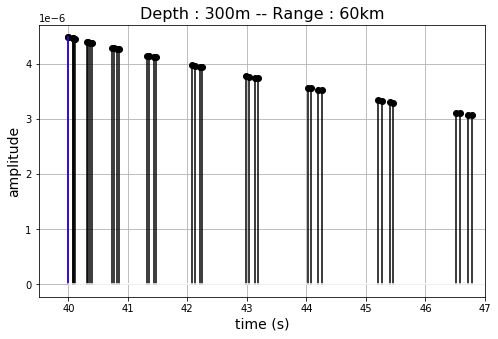

In [9]:
### PLOTS 
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
markerline, stemlines, baseline = plt.stem(TIMES, A)
plt.setp(stemlines, color = 'k')
plt.setp(stemlines[0], color = 'r')
plt.setp(stemlines[1], color = 'b')
plt.setp(markerline, color = 'k')
plt.setp(baseline, color='w') 

ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
#plt.yscale('log')
plt.title ('Depth : %dm -- Range : %.dkm' %(zr,r/1000.), fontsize=16)
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.xlim([39.5,47.])
plt.grid()

plt.savefig('rep_imp_anali', dpi=100)

---
# Toutes les réponses

In [10]:
Arr1, Pos1 = bell.read_arrivals_asc ('../files_arr/isocel_parfait.arr', Narrmx = 180)

Max.number of arrivals for source index 0 is 174


In [11]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.

In [12]:
### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos1['r']['range']==R[i])[0][0]

In [13]:
isd=0

NN=[]
MAT = np.zeros((D.size, R.size, 180))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        Narr = int(Arr1['Narr'][irr,ird,isd])
        NN.append(Narr)
        times = sorted(Arr1['delay'][irr, :Narr, ird, isd])
        MAT[i, j, :Narr] = times

In [14]:
c = 1500.      # célérité (en m/s)
N = 45

MAT_A = np.zeros((D.size, R.size, 180))

for i in range (D.size):
    for j in range(R.size):
        k+=1
        zr = D[i]                   # profondeur du récepteur
        r  = R[j]                   # range du récepteur
        zf = Z - zs - abs(zr - zs)  # profondeur entre récepteur et fond

        ###### Calcul de la réponse impulsionnelle
       
        DIST = []
        for n in range (N) : 
            ray1 = (2*n+1)*Z - zf - zs
            ray2 = (2*n+1)*Z - zf + zs
            ray3 = (2*n+1)*Z + zf - zs
            ray4 = (2*n+1)*Z + zf + zs
            Rays = [ray1, ray2, ray3, ray4]

            for m in range (len(Rays)):
                teta = np.arctan (Rays[m]/r)
                RR = r/np.cos(teta)
                DIST.append(RR)
                
        DIST = np.array(DIST)
        TIMES = DIST / c

        MAT_A[i, j, :] = sorted(TIMES)

In [19]:
diff = MAT[:,:,:18] - MAT_A[:,:,:18]
print('max  : ', np.max(abs(diff)))
print('mean : ', np.mean(abs(diff)))

max  :  5.616497638527562e-06
mean :  1.1949379114837043e-06
